# APS360 Traffic Sign Recognition Project

### Initialization & Loading the Data
A little bit of text to describe what's going on in the below code in case it helps. The first code block is importing all the modules that have been needed for the last 4 labs, so that we have any tool necessary for creating the CNN. The second code block mounts your Google Drive, since the data for working with the model is in Drive, so we need to be able to access it. The third code block changes the working directory that Colab is referencing to the Project folder. The fourth code block actually splits the images and makes the data loader objects, since those objects are how we're most familiar with making neural networks. It defines a transform to make the images into tensors, and then uses the same process (torchvision.datasets.ImageFolder()) to actually use the transform (I set up the data folder in a format that works with this function). It then does a 60/20/20 split for training, validation and testing. So the important variable names are:

TRAINING DATA: 'train_data' (~9000 images)

VALIDATION DATA: 'val_data' (~3000 images)

TESTING DATA: 'test_data' (~3000 images)

These are normal dataloader objects, like we've been working with in the last few labs. We should be able to use them like normal. 

In [ ]:
# start by importing all the necessary modules
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import math
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import PIL


if torch.cuda.is_available():
  torch.cuda.device("cuda")

In [ ]:
# Mount Google Drive so you can access the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# YOU WILL NEED TO CHANGE THE BELOW LINE OF CODE WITH THE PATH TO THE APS360 PROJECT FOLDER IN YOUR DRIVE
## After Drive is mounted, click on the folder icon to the left to access Files
## Open 'gdrive' and then 'MyDrive', then keep opening folders until you see our 'APS360 Project' shared folder
## Click on the three dots next to the folder and select 'Copy Path'
## paste the file path in quotes where the current string is below

#os.chdir('/content/gdrive/MyDrive/Academics ☔/UofT/3rd Year/APS360 (1)/APS360 Project')

# This cell has been modified to pull the data from google drive and copy it to the 
# host machine - makes training much faster. There are 2 zip files in the google drive
# data_full.zip - rgb  data
# data_equalized.zip - grayscale histogram equalized data
# the equalized data should be better for training but we'll find out once we train


os.chdir('/content/')

!rm -rf ./data

member = 'naman' # set to your name
data_version = "data_equalized.zip"

if member == 'naman':
  os.system(f'cp -r /content/gdrive/MyDrive/APS360\\ Project/{data_version} /content/')
if member == 'stella':
  os.system(f'cp -r /content/gdrive/MyDrive/Academics\\ ☔/UofT/3rd Year/APS360 (1)/APS360 Project/{data_version} /content/')
if member == 'wasif':
  os.system(f'cp -r /content/gdrive/myDrive/APS360 Project/{data_version} /content/')
if member == 'nathan':
  os.system(f'cp -r /content/gdrive/MyDrive/APS360_Project/{data_version} /content/')
os.system(f'unzip {data_version}')

0

In [ ]:
# define a transform to Tensors of normalized range [-1, 1].
transform = transforms.Compose([#transforms.ToPILImage(),
                                transforms.Grayscale(),
                                transforms.RandomAffine(degrees=15,
                                                        translate=(0,0.1),
                                                        scale=(1,1.3)),
                                #transforms.Normalize((0.5,), (0.5,)), #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                transforms.ToTensor()])
    
# Split into training, validation, and testing
img_data = torchvision.datasets.ImageFolder('/content/data/', transform=transform)
dataset_length = len(img_data)
data = torch.utils.data.random_split(img_data, [round(dataset_length*0.6), round(dataset_length*0.2), round(dataset_length*0.2)])

# # Define data sets
train_data = data[0]
val_data = data[1]
test_data = data[2]

# # Creating dataloaders for the data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data))
print('Number of Training Images: ', len(train_data), '\nPercent of Data Used in Training: ', round(len(train_data)/len(img_data)*100,1), '%')

val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
print('\nNumber of Validation Images: ', len(val_data), '\nPercent of Data Used in Validation: ', round(len(val_data)/len(img_data)*100,1), '%')

test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
print('\nNumber of Testing Images: ', len(test_data), '\nPercent of Data Used in Testing: ', round(len(test_data)/len(img_data)*100,1), '%')


Number of Training Images:  8895 
Percent of Data Used in Training:  60.0 %

Number of Validation Images:  2965 
Percent of Data Used in Validation:  20.0 %

Number of Testing Images:  2965 
Percent of Data Used in Testing:  20.0 %


Overall Data Distribution
[210 396 380 355 395 394 365 366 365 366 362 210 397 360 330 390 319 270
 370 355 240 376 270 386 364 394 240 381 343 378 390 210 383 300 388 360
 240 240 399 420 390 394 384]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42]), array([210, 396, 380, 355, 395, 394, 365, 366, 365, 366, 362, 210, 397,
       360, 330, 390, 319, 270, 370, 355, 240, 376, 270, 386, 364, 394,
       240, 381, 343, 378, 390, 210, 383, 300, 388, 360, 240, 240, 399,
       420, 390, 394, 384]))


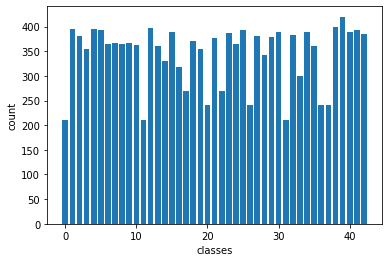

In [ ]:
print("Overall Data Distribution")
targets = np.array(img_data.targets)
print(np.bincount(targets))
print(np.unique(np.array(img_data.targets),return_counts=True))
classes,vals = np.unique(np.array(img_data.targets),return_counts=True)
plt.bar(classes,vals)
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
def get_data_loader(full_dataset,batch_size,display_dist=False):
    targets = np.array(full_dataset.targets)
    state = np.random.RandomState(1000)  #To ensure reproducibility

    # Split full_dataset into 80%(train+validation) 20% test
    train_full_idx, test_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True,stratify=targets,random_state=state)

    train_full_labels = targets[train_full_idx]
    test_labels = targets[test_idx]

    # Split train_full into 80% train and 20% validation (0.8*0.25=0.2)
    train_idx,validation_idx = train_test_split(train_full_idx,test_size=0.25,shuffle=True,stratify=train_full_labels,random_state=state)

    train_labels = targets[train_idx]
    validation_labels = targets[validation_idx]

    train_data_final = []
    train_labels_final = []

    # for i in range(train_idx.shape[0]):
    #   train_data_final.append(train_idx[i])
    #   train_data_final.append(gaussian(train_idx[i], sigma=1, multichannel=False)) #blur
    #   train_data_final.append(random_noise(train_idx[i], var=0.155**2)) #noise
    #   train_data_final.append(warp(img, AffineTransform(translation=(25,25)), mode='wrap')) #shift
    #   for j in range(4):
    #     train_labels_final.append(train_labels[i])

    if display_dist:
      print("Training set:")
      classes,vals = np.unique(train_labels,return_counts=True)
      plt.bar(classes,vals)
      #plt.hist(train_labels)
      plt.xlabel('classes')
      plt.ylabel('count')
      plt.show()
      print("Validation set:")
      #plt.hist(validation_labels)
      classes,vals = np.unique(validation_labels,return_counts=True)
      plt.bar(classes,vals)
      plt.xlabel('classes')
      plt.ylabel('count')
      plt.show()
      print("Test set:")
      classes,vals = np.unique(test_labels,return_counts=True)
      plt.bar(classes,vals)
      #plt.hist(test_labels)
      plt.xlabel('classes')
      plt.ylabel('count')
      plt.show()

    
    train_sampler = SubsetRandomSampler(train_idx)
    train_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=train_sampler)

    validation_sampler = SubsetRandomSampler(validation_idx)
    validation_loader = torch.utils.data.DataLoader(full_dataset,batch_size=batch_size,
                                                    num_workers=1,sampler=validation_sampler)

    test_sampler = SubsetRandomSampler(test_idx)
    test_loader = torch.utils.data.DataLoader(full_dataset)

    return train_loader,validation_loader,test_loader

Training set:


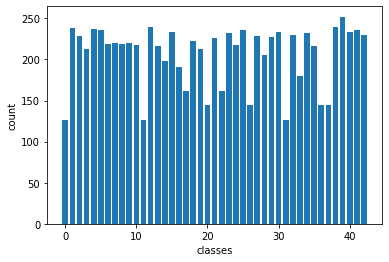

Validation set:


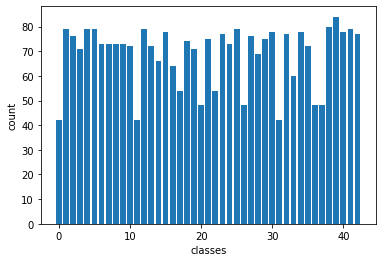

Test set:


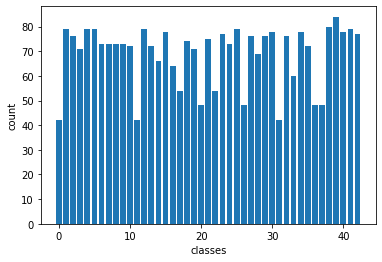

In [ ]:
_,_,_=get_data_loader(img_data,32,True)

Model Creation - 

adapted model from https://towardsdatascience.com/recognizing-traffic-signs-with-over-98-accuracy-using-deep-learning-86737aedc2ab

In [ ]:
class TrafficSignModel(nn.Module):
  def __init__(self):
    super(TrafficSignModel, self).__init__()
    self.conv1 = nn.Conv2d(1,64,3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(64,128,3)
    self.conv3 = nn.Conv2d(128,256,3)
    self.fc1 = nn.Linear(256,120)
    self.fc2 = nn.Linear(120, 43)
    self.name = "TrafficSignModel"

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1,1*1*256)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

Training Code


In [ ]:
def get_accuracy(model, data_loader):
  for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        correct = 0
        total = 0
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

  return correct / total  


def train_net(model, train_loader, valid_loader, batch_size=32, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    iterations, losses, train_acc, valid_acc = [], [], [], []
    
    if torch.cuda.is_available():
      model.cuda()
    append = True
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
      
      for imgs, labels in train_loader:
          if torch.cuda.is_available():
            labels = labels.cuda()
            imgs = imgs.cuda()
          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch

          if append:
            iterations.append(n)
            losses.append(float(loss)/batch_size)
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            valid_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
            n+=1
            append = False


      # save the current training information
      iterations.append(n)
      losses.append(float(loss)/batch_size)             # compute *average* loss
      train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
      valid_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
      n += 1

    plt.title("Training Curve")
    plt.plot(iterations, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iterations, train_acc, label="Train")
    plt.plot(iterations, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))
    print('Finished Training')

Alternate training code

In [ ]:
!mkdir model_checkpoints


def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        total_err += calculate_classification_error(outputs,labels)   
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def calculate_classification_error(model_output,labels):
    res = torch.softmax(model_output,dim=1)
    _,res_tags = torch.max(res,dim=1)

    num_correct = (res_tags == labels).float().sum()
    # print(res_tags)
    # print(labels)

    return len(labels) - num_correct

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), 1-train_err, label="Train")
    plt.plot(range(1,n+1), 1-val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def train_model(net,train_loader,validation_loader, batch_size=64,lr=0.01,num_epochs=30,plot_curve=False):
  
    #train_loader,validation_loader,_ = get_data_loader(batch_size=batch_size,display_dist=False)

    torch.manual_seed(1000)

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)
    optimizer = optim.Adam(net.parameters(),lr=lr)


    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    if torch.cuda.is_available():
      net.cuda()

    for epoch in range(num_epochs):
        total_train_loss = 0
        total_train_err = 0
        total_epoch = 0

        for i,data in enumerate(train_loader,0):
            inputs, labels = data
            # labels = normalize_labels(labels)
            if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()

            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            total_train_err +=  calculate_classification_error(outputs,labels)
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err)/total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch] , val_loss[epoch] = evaluate(net,validation_loader,criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   1-train_err[epoch],
                   train_loss[epoch],
                   1-val_err[epoch],
                   val_loss[epoch]))
        
        if not os.path.exists(f"model_checkpoints/{net.name}"):
          os.mkdir(f"model_checkpoints/{net.name}")
        model_path = f"./model_checkpoints/{net.name}/{net.name}_{batch_size}_{lr}_{epoch}"
        torch.save(net.state_dict(),model_path)
    print('Finished Training')
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    if plot_curve:
      plot_training_curve(model_path)

# Training

In [ ]:
train_loader, valid_loader, test_loader = get_data_loader(img_data, 32, False)

Epoch 1: Train acc: 0.04631815626756608, Train loss: 3.6100438155716272 |Validation acc: 0.08903878583473857, Validation loss: 3.281467290634805
Epoch 2: Train acc: 0.19651489600899386, Train loss: 2.770914612914161 |Validation acc: 0.3264755480607082, Validation loss: 2.2224906606877104
Epoch 3: Train acc: 0.4052838673412029, Train loss: 1.8763701752793016 |Validation acc: 0.5072512647554805, Validation loss: 1.5693602409768612
Epoch 4: Train acc: 0.5444631815626757, Train loss: 1.423984031883075 |Validation acc: 0.6094435075885329, Validation loss: 1.24417253123953
Epoch 5: Train acc: 0.6381112984822934, Train loss: 1.1334495527281179 |Validation acc: 0.6812816188870152, Validation loss: 1.0171954885442207
Epoch 6: Train acc: 0.699044406970208, Train loss: 0.935947159640223 |Validation acc: 0.7372681281618887, Validation loss: 0.8405557439682332
Epoch 7: Train acc: 0.7566048341765037, Train loss: 0.7561405910004815 |Validation acc: 0.790893760539629, Validation loss: 0.68053391005130

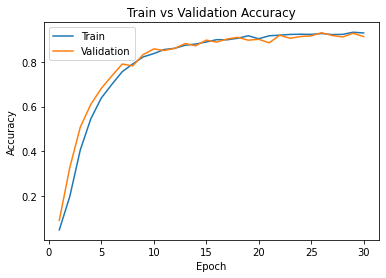

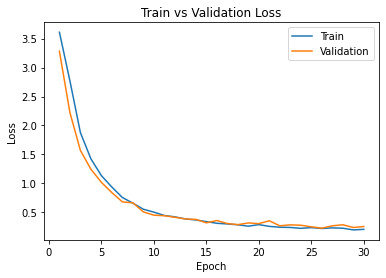

In [ ]:
train_loader, valid_loader, test_loader = get_data_loader(img_data, 64, False)
model = TrafficSignModel()
train_model(model,train_loader,valid_loader,batch_size=64,lr=0.002,num_epochs=30,plot_curve=True)

Epoch 1: Train acc: 0.04035975267003933, Train loss: 3.6213238187831083 |Validation acc: 0.11163575042158513, Validation loss: 3.156813621520996
Epoch 2: Train acc: 0.2459808881394041, Train loss: 2.466747587533306 |Validation acc: 0.4114671163575042, Validation loss: 1.8247158958556804
Epoch 3: Train acc: 0.5105115233277122, Train loss: 1.4890831541672027 |Validation acc: 0.6370994940978078, Validation loss: 1.131247470987604
Epoch 4: Train acc: 0.6468802698145025, Train loss: 1.0650106183916546 |Validation acc: 0.7032040472175379, Validation loss: 0.9302320619846912
Epoch 5: Train acc: 0.7304103428892637, Train loss: 0.8048993160398744 |Validation acc: 0.7426644182124789, Validation loss: 0.8180002887198266
Epoch 6: Train acc: 0.7553681843732434, Train loss: 0.7386277238670871 |Validation acc: 0.7672849915682968, Validation loss: 0.7100033836161836
Epoch 7: Train acc: 0.7787521079258011, Train loss: 0.6664517438240188 |Validation acc: 0.7821247892074199, Validation loss: 0.6652477656

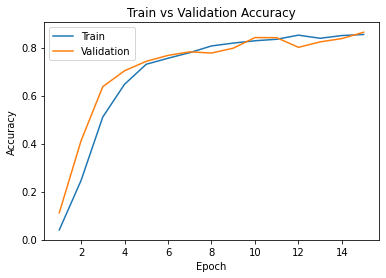

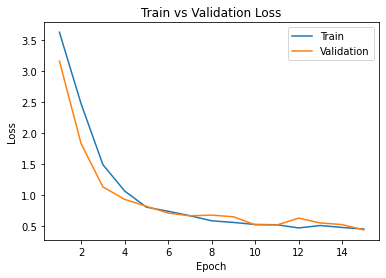

In [ ]:
#original number of parameters
#SGD optimizer
train_loader, valid_loader, test_loader = get_data_loader(img_data, 64, False)
model = TrafficSignModel()
train_model(model,train_loader,valid_loader,batch_size=64,lr=0.01,num_epochs=15,plot_curve=True)
#train_net(model, train_loader, valid_loader, num_epochs=10, batch_size=64)#, 64, 10, 0.001) -> not sure if something is broken but this one is getting stuck in a loop

Epoch 1: Train acc: 0.06070826306914001, Train loss: 3.5666141844481873 |Validation acc: 0.11602023608768974, Validation loss: 3.1276217788778324
Epoch 2: Train acc: 0.3231028667790894, Train loss: 2.268615789979482 |Validation acc: 0.4863406408094435, Validation loss: 1.6508593238810056
Epoch 3: Train acc: 0.5512085441259134, Train loss: 1.4078084560606976 |Validation acc: 0.6445193929173694, Validation loss: 1.1534686896108812
Epoch 4: Train acc: 0.6715008431703204, Train loss: 1.0298353857059273 |Validation acc: 0.7234401349072512, Validation loss: 0.8781599383200368
Epoch 5: Train acc: 0.7550309162450815, Train loss: 0.776036674277388 |Validation acc: 0.8026981450252951, Validation loss: 0.6702474150606381
Epoch 6: Train acc: 0.8057335581787521, Train loss: 0.6126554032667078 |Validation acc: 0.8050590219224283, Validation loss: 0.6066495886733455
Epoch 7: Train acc: 0.8375491849353569, Train loss: 0.5073921810165584 |Validation acc: 0.8505902192242834, Validation loss: 0.486423827

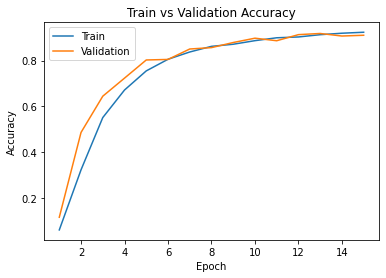

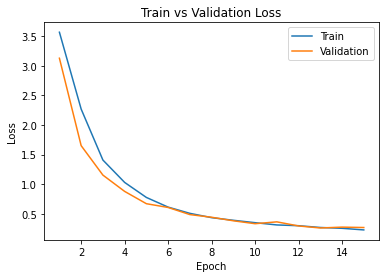

In [ ]:
#more parameters (doubled the number of hidden units at each convolutional layer)
#used Adam optimizer instead of SGD
#lowered batch size
train_loader, valid_loader, test_loader = get_data_loader(img_data, 32, False)
model = TrafficSignModel()
train_model(model,train_loader,valid_loader,batch_size=32,lr=0.001,num_epochs=15,plot_curve=True)

Epoch 1: Train acc: 0.9579539066891513, Train loss: 0.13333725333213806 |Validation acc: 0.9382799325463743, Validation loss: 0.19432041545708975
Epoch 2: Train acc: 0.9595278246205734, Train loss: 0.12679947252784457 |Validation acc: 0.9521079258010118, Validation loss: 0.1518868375569582
Epoch 3: Train acc: 0.9620011242270938, Train loss: 0.11631292275020054 |Validation acc: 0.9467116357504216, Validation loss: 0.18168517760932446
Epoch 4: Train acc: 0.9648116919617763, Train loss: 0.11562836691737174 |Validation acc: 0.9322091062394604, Validation loss: 0.22230334704120955
Epoch 5: Train acc: 0.9669477234401349, Train loss: 0.11345274437751089 |Validation acc: 0.945362563237774, Validation loss: 0.16796656573812166
Epoch 6: Train acc: 0.9648116919617763, Train loss: 0.1151495065007891 |Validation acc: 0.9460370994940979, Validation loss: 0.16195346228778362
Epoch 7: Train acc: 0.9634626194491287, Train loss: 0.1183599733880588 |Validation acc: 0.9460370994940979, Validation loss: 0.

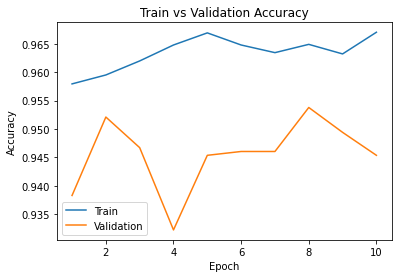

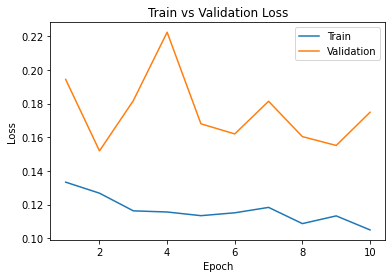

In [ ]:
#10 epochs on batch size 32 and 5 epochs on batch size 256
train_loader, valid_loader, test_loader = get_data_loader(img_data, 256, False)
train_model(model,train_loader,valid_loader,batch_size=256,lr=0.001,num_epochs=10,plot_curve=True)

In [ ]:
err, loss = evaluate(model, test_loader, criterion=nn.CrossEntropyLoss())
print("Test Accuracy: {:.4f}".format(1-err))
print("Test Loss: {:.4f}".format(loss))

Test Accuracy: 0.9582
Test Loss: 0.1399


Testing best model with each class 


In [ ]:
test_data_classes = [[] for i in range(43)]

for data in test_data:
  for i in range(43):
    if data[1] == i:
      test_data_classes[i].append(data)

test_loader_classes = []

for i in range(43):
  test_loader_classes.append(torch.utils.data.DataLoader(test_data_classes[i], batch_size=len(test_data_classes[i])))

test_data_class0 = []
for data in test_data:
  if(data[1] == 0):
    test_data_class0.append(data)

errors = np.zeros(43)
losses = np.zeros(43)

for i in range(43):
  errors[i], losses[i] = evaluate(model, test_loader_classes[i], criterion=nn.CrossEntropyLoss())

accuracies = 1-errors


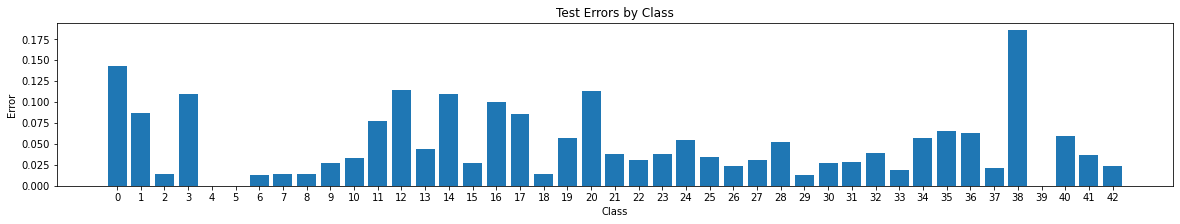

In [ ]:
x = [i for i in range(43)]

plt.figure(figsize=(20, 3))
plt.xticks(x)
plt.bar(x, errors)
plt.xlabel("Class")
plt.ylabel("Error")
plt.title("Test Errors by Class")
plt.show()

In [ ]:
print("Worst class, class {}, in terms of error with error: {:.4f}".format(np.argmax(errors), max(errors)))

Worst class, class 38, in terms of error with error: 0.0941


In [ ]:
errors_labelled = []

for i in range(43):
  errors_labelled.append((errors[i], i))

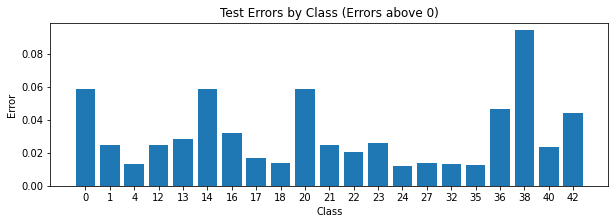

In [ ]:
def filter_err(err):
  if(err[0] == 0):
    return False
  else:
    return True

filtered_errs = filter(filter_err, errors_labelled)

errors_filtered = []
x = []
for err in filtered_errs:
  #print(err)
  errors_filtered.append(err[0])
  x.append(err[1])

x_axis = [i for i in range(len(x))]
plt.figure(figsize=(10, 3))
plt.xticks(x_axis, x)
plt.bar(x_axis, errors_filtered)
plt.xlabel("Class")
plt.ylabel("Error")
plt.title("Test Errors by Class (Errors above 0)")
plt.show()


In [ ]:
err, loss = evaluate(model, test_loader_classes[20], criterion=nn.CrossEntropyLoss())

In [ ]:
import torch.onnx
dummy_input = torch.randn(1,1,28,28)
torch.onnx.export(model.cpu(),dummy_input,"/content/TrafficSignNetExport",verbose=True)

graph(%input.1 : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv1.weight : Float(64, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %conv3.weight : Float(256, 128, 3, 3, strides=[1152, 9, 3, 1], requires_grad=1, device=cpu),
      %conv3.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %fc1.weight : Float(120, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(120, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(43, 120, strides=[120, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(43, strides=[1], requires_grad=1, device=cpu)):
  %11 : Float(1, 64, 26, 26, strides=[43264, 676, 26, 1], requires_grad=1, device=cpu

In [ ]:

dict((int(v),int(k)) for k,v in img_data.class_to_idx.items())

{0: 0,
 1: 1,
 2: 10,
 3: 11,
 4: 12,
 5: 13,
 6: 14,
 7: 15,
 8: 16,
 9: 17,
 10: 18,
 11: 19,
 12: 2,
 13: 20,
 14: 21,
 15: 22,
 16: 23,
 17: 24,
 18: 25,
 19: 26,
 20: 27,
 21: 28,
 22: 29,
 23: 3,
 24: 30,
 25: 31,
 26: 32,
 27: 33,
 28: 34,
 29: 35,
 30: 36,
 31: 37,
 32: 38,
 33: 39,
 34: 4,
 35: 40,
 36: 41,
 37: 42,
 38: 5,
 39: 6,
 40: 7,
 41: 8,
 42: 9}

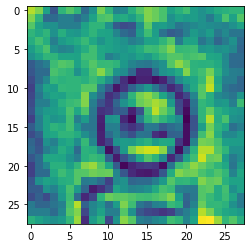

In [ ]:
plt.imshow(img_data[770][0].squeeze(0))

[[[0.3254902  0.25490198 0.21568628 1.        ]
  [0.32941177 0.25490198 0.24313726 1.        ]
  [0.32941177 0.2509804  0.23529412 1.        ]
  ...
  [0.34509805 0.2627451  0.24705882 1.        ]
  [0.34117648 0.2509804  0.21568628 1.        ]
  [0.32941177 0.26666668 0.29803923 1.        ]]

 [[0.3372549  0.25882354 0.24705882 1.        ]
  [0.33333334 0.24313726 0.23137255 1.        ]
  [0.32156864 0.23529412 0.21960784 1.        ]
  ...
  [0.34117648 0.24705882 0.23921569 1.        ]
  [0.3372549  0.24705882 0.21176471 1.        ]
  [0.34509805 0.2627451  0.2901961  1.        ]]

 [[0.32941177 0.25490198 0.23921569 1.        ]
  [0.31764707 0.23529412 0.21960784 1.        ]
  [0.3137255  0.22745098 0.21176471 1.        ]
  ...
  [0.32941177 0.24705882 0.21960784 1.        ]
  [0.32156864 0.24313726 0.21568628 1.        ]
  [0.32941177 0.2627451  0.29411766 1.        ]]

 ...

 [[0.29411766 0.21960784 0.21176471 1.        ]
  [0.28627452 0.22352941 0.21176471 1.        ]
  [0.30980

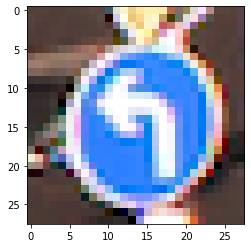

In [ ]:
img = plt.imread("/content/data/34/00034_00000_00010.png")
plt.imshow(img)
print(img)
img_tensor = torch.Tensor(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.unsqueeze(0)
#torch.max(torch.softmax(model(img_tensor),dim=1),1)

In [ ]:
# importing all the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt
% matplotlib inline

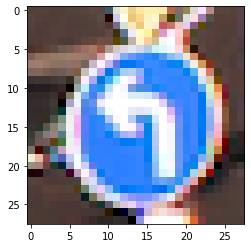

In [ ]:
plt.imshow(img)
plt.imsave("non_rotated.jpg",img)

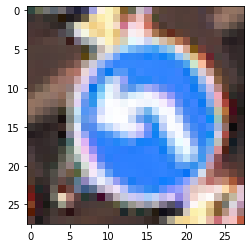

In [ ]:
rotated = rotate(img, angle=25, mode = 'wrap')
plt.imshow(rotated)
plt.imsave("rotated.jpg",rotated)

Text(0.5, 1.0, 'Wrap Shift')

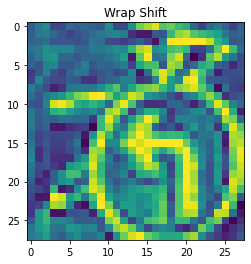

In [ ]:
transform = AffineTransform(translation=(25,25))
wrapShift = warp(img,transform,mode='wrap')
plt.imshow(wrapShift)
plt.title('Wrap Shift')

Text(0.5, 1.0, 'Random Noise')

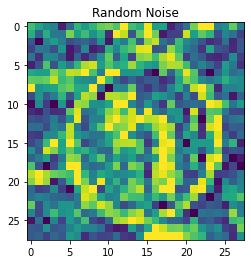

In [ ]:
randoNoise = random_noise(img,var=0.155**2)

plt.imshow(randoNoise)
plt.title('Random Noise')

Text(0.5, 1.0, 'Blurred Image')

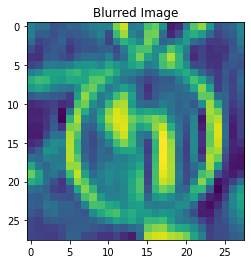

In [ ]:
blurred = gaussian(img,sigma=1,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')

# Image Validation

tensor(3)


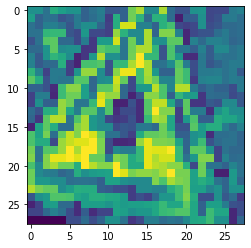

In [ ]:
for data,labels in train_loader:
  print(labels[0])
  #print(data[0].squeeze(0)*255)
  plt.imshow(data[0].squeeze(0)*255)
  plt.imsave("aug.jpg",data[0].squeeze(0)*255)
  break